https://www.kaggle.com/datasets/tunguz/used-car-auction-prices?resource=download

## What
Predict what a car will sell for at Auction given 
features of the car such as make, model, condition, odometer, et cetera.


# Why
Could be useful for buyers so they can guage their bids.
Also useful for sellers to give an idea of what a car is worth at auction.


In [1]:
import os
import pandas as pd
import sklearn
from IPython.display import display

In [3]:
try:
  import google.colab
  COLAB = True
except:
  COLAB = False

In [5]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  source_dir = '/content/gdrive/MyDrive/data/'
  os.listdir(source_dir)
else:
  source_dir = "."
fpath = os.path.join(source_dir, "car_prices.csv")
orig = pd.read_csv(fpath, on_bad_lines="skip" )
orig.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(558811, 16)

In [9]:
""" Some functions to compile a "summary" of a data frame
    including types, number unique, min and max """

def getTypes(df):
    serlist  = []
    temp = df.applymap(type)
    for col in temp.columns:
        ser = pd.Series(name=col, dtype="float32")
        ser[col] = temp[col].unique()
        serlist.append(ser)
    ser = pd.concat(serlist)
    ser.name = "dtypes"
    return ser

def getMinMax(df):
    minser = pd.Series(name="min", dtype="float32")
    maxser = pd.Series(name="max", dtype="float32")
    for col in df.columns:
        try:
            minser[col] = df.loc[df[col].notnull(), col].min()
            maxser[col] = df.loc[df[col].notnull(), col].max()
        except:
            minser[col] = None
            maxser[col] = None
    res = pd.merge(minser, maxser, left_index=True, right_index=True)
    return res

def dfSummary(df):
    sdf = pd.DataFrame(df.isnull().sum(), columns=["nulls"])
    temp = pd.DataFrame(getTypes(df), columns=["dtypes"])
    sdf = sdf.merge(temp, how="left", left_index=True, right_index=True)
    temp = pd.DataFrame(df.nunique(), columns=["nunique"])
    sdf = sdf.merge(temp, how="left", left_index=True, right_index=True)
    sdf = sdf.merge(getMinMax(df), how="left", left_index=True, right_index=True)    
    return sdf

In [10]:
dfSummary(orig)

,nulls,dtypes,nunique,min,max
year,0,[<class 'int'>],34,1982,2015
make,10301,"[<class 'str'>, <class 'float'>]",96,Acura,vw
model,10399,"[<class 'str'>, <class 'float'>]",973,1,yukon
trim,10651,"[<class 'str'>, <class 'float'>]",1975,!,zx3
body,13195,"[<class 'str'>, <class 'float'>]",86,Access Cab,xtracab
transmission,65353,"[<class 'str'>, <class 'float'>]",2,automatic,manual
vin,0,[<class 'str'>],550296,137fa90362e197965,zhwgu22t97la05738
state,0,[<class 'str'>],38,ab,wi
condition,11794,[<class 'float'>],41,1.0,5.0
odometer,94,[<class 'float'>],172277,1.0,999999.0


### Observations on original data
- there are a lot of nulls, but still relatively small
   in comparison to the half a million records
- some columns have string and float, probably np.nan values
- some of the categorical variables have a large number of 
    different values, maybe too many for one-hot encoding
    Here I am thinking mainly of Model which I expect
    could be a useful feature
- looks like there are some bad values in some columns,
 e.g. Min for Model is 1.

### Drop nulls
Lets try dropping all rows with null values and see what we have left.


In [11]:
nn = orig.dropna().copy()
nn.shape

(472336, 16)

Still over 450,000 records.  That might be enough for a model.
At some point it might be worth some analysis of the distribution
of the records with null values, but not now.

In [12]:
# add a real date column from the string date and show summary again
nn["selldt"] = pd.to_datetime(orig["saledate"])
dfSummary(nn)

,nulls,dtypes,nunique,min,max
year,0,[<class 'int'>],26,1990,2015
make,0,[<class 'str'>],53,Acura,smart
model,0,[<class 'str'>],768,1 Series,xD
trim,0,[<class 'str'>],1507,!,xDrive50i
body,0,[<class 'str'>],85,Access Cab,xtracab
transmission,0,[<class 'str'>],2,automatic,manual
vin,0,[<class 'str'>],465779,137za84341e193591,zhwgu22t97la05738
state,0,[<class 'str'>],34,al,wi
condition,0,[<class 'float'>],41,1.0,5.0
odometer,0,[<class 'float'>],160427,1.0,999999.0


In [ ]:
import sklearn
from sklearn.cluster import KMeans
X = nn[["make", "sellingprice"]]
#kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(X)
acol = "make"
cols = [acol, "sellingprice"]
x = nn[cols].groupby(acol).agg(["mean", 'count', 'std'])
x = x.sort_values(by=('sellingprice',  'count'))
x.head(30)

sellingprice                    
                       mean count           std
make                                           
Lotus          40800.000000     1           NaN
Daewoo           450.000000     2    212.132034
Lamborghini   111500.000000     3   5408.326913
Fisker         46461.111111     9   4891.432419
Geo              576.562500    16    363.944679
Rolls-Royce   153456.250000    16  10834.080102
Plymouth       11845.312500    16  11388.650120
Ferrari       128852.941176    17  23901.990441
Tesla          67054.347826    23   9675.988475
Aston Martin   55500.000000    24  14861.271524
Bentley        72713.333333   105  30383.470856
Maserati       43729.816514   109  22716.924592
Isuzu           1774.162011   179   1520.124596
Oldsmobile       953.773585   318    711.616039
smart           6301.603499   343   1809.620666
Saab            3616.346154   416   2783.764828
FIAT            9927.416552   725   2448.362816
HUMMER         15404.606771   768   6510.388544
Suzuki          4009.769703   977   2810.169394
Porsche        38932.109767  1157  24969.528835
Jaguar         19429.853620  1257  18925.574230
Land Rover     33225.287443  1322  20781.991592
Scion           9736.213592  1545   4705.528894
Mercury         3996.944621  1571   3190.500713
Saturn          3436.381323  2570   2655.288307
MINI           12389.426341  2946   5684.606426
Volvo          10927.677482  3082   9442.176989
Mitsubishi      8035.456979  3661   5869.461287
Pontiac         3814.864609  4018   2816.749861
Ram            25257.458210  4044   8802.138228

In [ ]:
nn[["make", "model", "sellingprice"]].sort_values(by="sellingprice").tail()

,make,model,sellingprice
125095,Rolls-Royce,Ghost,169500
545500,Rolls-Royce,Ghost,171500
446941,Mercedes-Benz,S-Class,173000
548146,Ferrari,458 Italia,183000
344905,Ford,Escape,230000


In [ ]:
dtypes = nn.dtypes
cols = ["make_model"]
for col in cols:
    if dtypes[col] != "object":
        continue
    print(col, nn[col].nunique())
    display(nn[col].value_counts().head(20))

make_model 772


NISSAN_ALTIMA               16346
FORD_FUSION                 12117
FORD_F-150                  11950
TOYOTA_CAMRY                10986
FORD_ESCAPE                 10656
FORD_FOCUS                   9547
HONDA_ACCORD                 8547
CHEVROLET_IMPALA             7500
BMW_3 SERIES                 7132
HONDA_CIVIC                  7068
DODGE_GRAND CARAVAN          6966
INFINITI_G SEDAN             6939
TOYOTA_COROLLA               6745
CHEVROLET_MALIBU             6292
FORD_EXPLORER                6242
HYUNDAI_SONATA               5788
CHEVROLET_SILVERADO 1500     5685
NISSAN_MAXIMA                5470
CHEVROLET_CRUZE              5404
HYUNDAI_ELANTRA              5344
Name: make_model, dtype: int64

In [ ]:
x = pd.DataFrame(nn["model"].value_counts())
x.columns = ["cnt"]
x["pct"] = x["cnt"] / x["cnt"].sum()
x["cum_pct"] = x.pct.cumsum()
x.loc[x.cnt > 200, ].shape

(297, 3)

In [ ]:
nn.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate', 'dt', 'make_model'],
      dtype='object')

<AxesSubplot:xlabel='mmr', ylabel='sellingprice'>

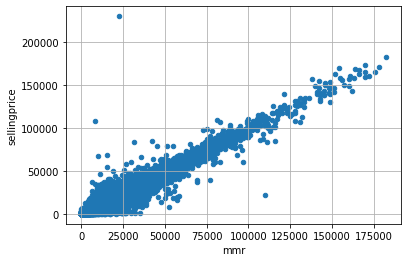

In [ ]:
nn.plot.scatter(x="mmr", y="sellingprice", grid=True)

In [ ]:
nn.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,dt,make_model
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00+08:00,KIA_SORENTO
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00+08:00,KIA_SORENTO


array([[<AxesSubplot:title={'center':'sellingprice'}>]], dtype=object)

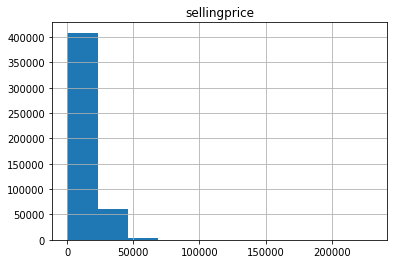

In [ ]:
nn.hist(column="sellingprice", bins=10)